# XGBoost Kornelia

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error, \
                            r2_score, mean_absolute_error

In [3]:
data = pd.read_csv('data/bitcoin/bitcoin_preprocessed.csv', index_col="Date", parse_dates=["Date"])
data

,Price,Open,High,Low,Vol.,Change %,Average
Date,,,,,,,
2010-07-18,0.1,0.0,0.1,0.1,0.08K,0.00%,0.10
2010-07-19,0.1,0.1,0.1,0.1,0.57K,0.00%,0.10
2010-07-20,0.1,0.1,0.1,0.1,0.26K,0.00%,0.10
2010-07-21,0.1,0.1,0.1,0.1,0.58K,0.00%,0.10
2010-07-22,0.1,0.1,0.1,0.1,2.16K,0.00%,0.10
...,...,...,...,...,...,...,...
2024-12-28,95284.5,94274.9,95684.3,94124.7,32.97K,1.07%,94904.50
2024-12-29,93716.3,95282.6,95315.4,93026.7,47.71K,-1.65%,94171.05
2024-12-30,92779.8,93718.7,94936.4,91522.3,112.43K,-1.00%,93229.35


In [4]:
tstart = '2016-01-08'
tend = '2023-03-01'

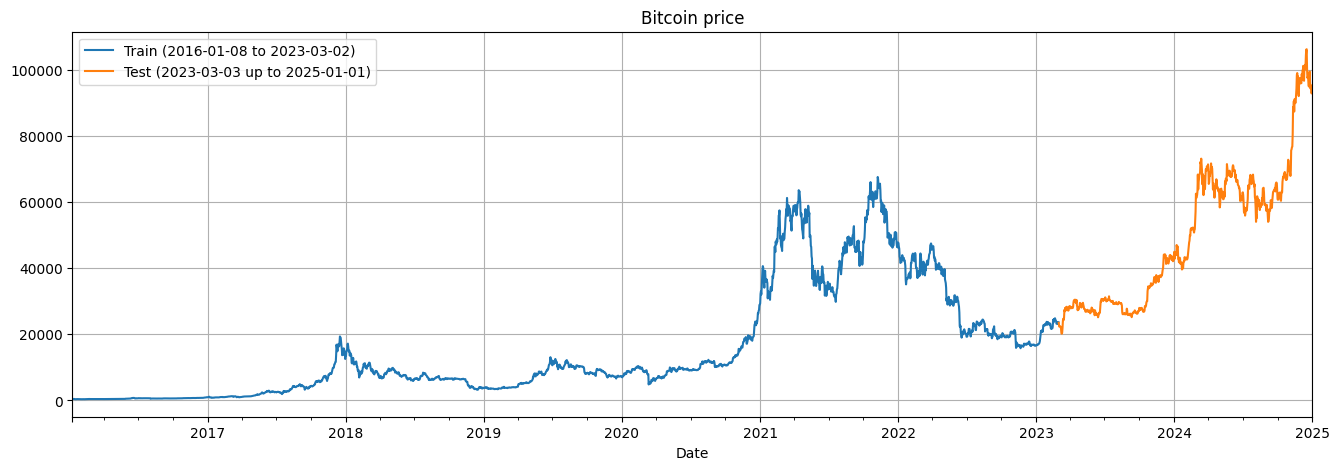

In [5]:
def train_test_plot(data, tstart, tend):
    tstart = pd.to_datetime(tstart)
    tend = pd.to_datetime(tend)
    tend_next = tend + pd.Timedelta(days=1)

    data.loc[tstart:tend, "Price"].plot(figsize=(16, 5), legend=True)
    data.loc[tend_next:, "Price"].plot(figsize=(16, 5), legend=True)

    plt.legend([f"Train (2016-01-08 to {tend_next.date()})", f"Test ({tend_next.date() + pd.Timedelta(days=1)} up to 2025-01-01)"])
    plt.title("Bitcoin price")
    plt.grid()
    plt.show()

train_test_plot(data, tstart, tend)

In [8]:
def train_test_split(data, tstart, tend):
    tend_next = pd.to_datetime(tend) + pd.Timedelta(days=1)

    train = data.loc[tstart:tend, "Price"].values
    test = data.loc[tend_next:, "Price"].values
    return train, test

training_set, test_set = train_test_split(data, tstart, tend)

In [10]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [11]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [12]:
from xgboost import XGBRegressor

In [13]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [14]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

# Initialize the model
model = XGBRegressor(
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=1.0
)
# Fit the model
model.fit(X_train_reshaped, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
dataset_total = data.loc[:, "Price"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * features)
#prediction
predicted_stock_price = model.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

In [16]:
def plot_predictions(test, predicted):
    plt.figure(figsize=(16, 9))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Bitcoin Price Prediction with XGBoost")
    plt.xlabel("Time")
    plt.ylabel("Bitcoin Price ($)")
    plt.legend()
    plt.show()

In [17]:
def evaluate_model(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    mae = mean_absolute_error(test, predicted)
    r2 = r2_score(test, predicted)
    msle = mean_squared_log_error(test, predicted)
    mape = np.mean(np.abs((test - predicted) / test)) * 100
    
    print(f"The root mean squared error is {rmse:.2f}")
    print(f"The Mean Absolute Error (MAE) is {mae:.2f}")
    print(f"The R-squared (R²) score is {r2:.4f}\n")
    print(f"The Mean Squared Logarithmic Error (MSLE) is {msle:.6f}")
    print(f"The Mean Absolute Percentage Error (MAPE) is {mape:.2f}%.")
     

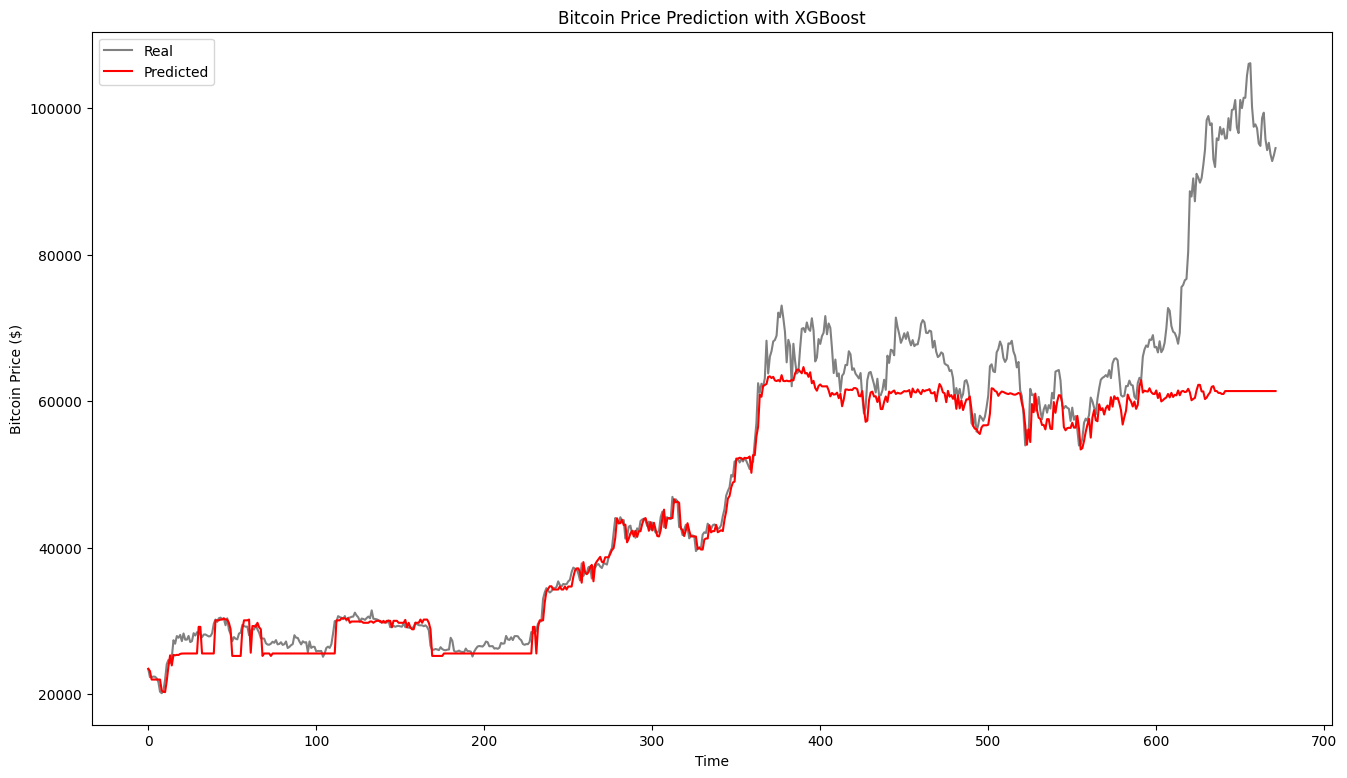

In [18]:
plot_predictions(test_set, predicted_stock_price)

In [19]:
evaluate_model(test_set, predicted_stock_price)

The root mean squared error is 10399.80
The Mean Absolute Error (MAE) is 4949.53
The R-squared (R²) score is 0.7589

The Mean Squared Logarithmic Error (MSLE) is 0.019595
The Mean Absolute Percentage Error (MAPE) is 46.51%.
